In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import norm, mannwhitneyu
import pylab

from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

In [2]:
groups = pd.read_csv("Проект_2_groups.csv", sep=";")
#
group_add = pd.read_csv("Проект_2_group_add.csv", sep=",")

active_studs = pd.read_csv("Проект_2_active_studs.csv", sep=";")

checks = pd.read_csv("Проект_2_checks.csv", sep=";")


In [3]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [4]:
group_add.isna().sum()

id     0
grp    0
dtype: int64

In [5]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [6]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

Пропуски отсутвуют!👍

In [7]:
active_studs['active'] = 1
checks['bought'] = 1

In [8]:
#Обьединим все датасеты в один большой датасет

full_group = pd.concat([groups, group_add], ignore_index=True)

d = active_studs.merge(full_group, left_on='student_id', right_on='id')

df = d.merge(checks, how='left', on='student_id')
df

,student_id,active,id,grp,rev,bought
0,581585,1,581585,A,NaN,NaN
1,5723133,1,5723133,A,NaN,NaN
2,3276743,1,3276743,B,NaN,NaN
3,4238589,1,4238589,A,NaN,NaN
4,4475369,1,4475369,B,NaN,NaN
...,...,...,...,...,...,...
8336,1794344,1,1794344,B,NaN,NaN
8337,296883,1,296883,B,NaN,NaN
8338,3598448,1,3598448,B,NaN,NaN
8339,3610547,1,3610547,B,290.0,1.0


In [9]:
print(d.shape)
print(active_studs.shape)

(8341, 4)
(8341, 2)


Метрики которые нас интересуют: 
кол-во активных пользователей и чеков, 
медианный, средний, максимальный и минимальный чеки, ну и конверсию, конечно же

In [10]:
mtrc = df.groupby('grp') \
    .agg({'student_id':'count', 'rev': ['median', 'mean', 'count', 'min', 'max']}) \
    .reset_index()
mtrc.columns = [
    'group', 'active', 'median_check', 'mean_check', 'count_check', 'min_check', 'max_check'
                    ]
ab = mtrc.groupby('group') \
    .apply(lambda x: x['count_check'].sum() / x['active'].sum()*100)

mtrc['conv'] = mtrc['group'].map(ab)
mtrc

,group,active,median_check,mean_check,count_check,min_check,max_check,conv
0,A,1538,585.0,933.589744,78,199.0,3660.0,5.071521
1,B,6803,1140.0,1257.878992,314,199.0,4650.0,4.615611


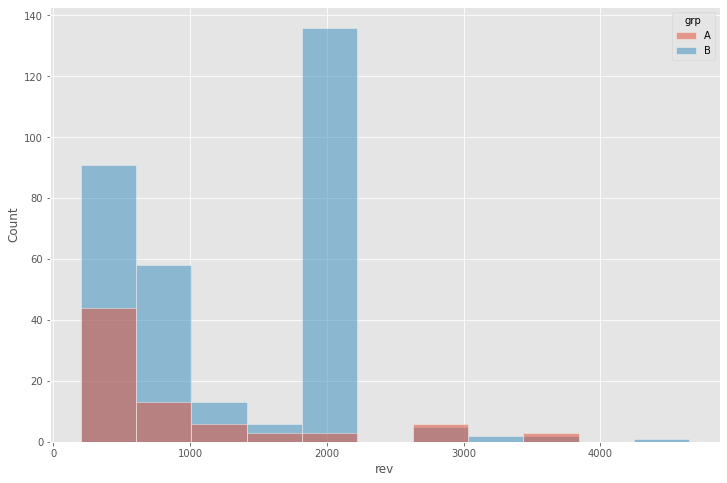

In [11]:
sns.histplot(data=df, x='rev', hue='grp')

Как мы видим, распределение далеко от нормального. Но давайте, всё-таки, проверим это используя Шапиро-тест

Наша выборка ну уж совсем маленькая(в А группе всего 78 человек), без бутстрапа тут не обойтись 

In [12]:
print(stats.shapiro(df.query('grp=="A"')['rev'].dropna()))
stats.shapiro(df.query('grp=="B"')['rev'].dropna())

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)


ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)

In [13]:
#Let's declare a function that will allow testing hypotheses using bootstrap
def get_bootstrap(
    data_column_1, # first sample numeric values
    data_column_2, # second sample numeric values
    boot_it = 1000, # number of bootstrap subsamples
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Visualization
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

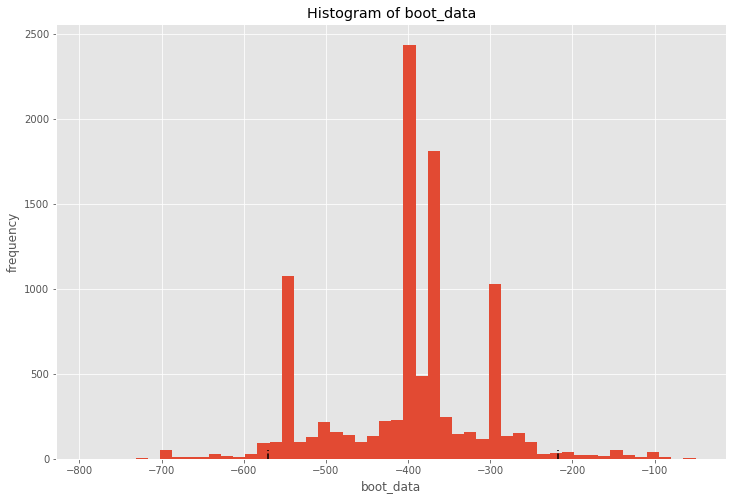

In [14]:
bootstrap =  get_bootstrap(df.query('grp == "A"')['rev'].dropna(),
                     df.query('grp == "B"')['rev'].dropna(),
                     boot_it = 10000, 
                     statistic = np.median, #Стат.критерий именно медиана, т.к распределение ненормально
                     bootstrap_conf_level = 0.95)

In [15]:
print(bootstrap["p_value"])
bootstrap["ci"]

2.359338460978621e-05


,0
0.025,-570.00
0.975,-217.95


In [16]:
df.query("grp == 'B'").rev.median() - df.query("grp == 'A'").rev.median()

555.0

2 TASK

In [17]:
import sqlite3

In [18]:
sqlite3.sqlite_version
con = sqlite3.connect('db')

def select(sql):
  return pd.read_sql(sql,con)

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

In [19]:
#Для удобства создадим таблицу
correct = np.random.choice([True, False], size=65000, p=[0.8, 0.2])
subjects = np.random.choice(['math', 'stat', 'python', 'sql'], 
                      size=65000, p=[0.25, 0.25, 0.25, 0.25])
st_id = np.random.randint(0, 65, size=65000)
date = pd.to_datetime(
    pd.Series(np.random.choice(pd.date_range(start='2020/03/01', end='2020/03/31'),
                                 size=65000)).astype('str') + ' ' +
    pd.Series(np.random.choice(3, size=65000)).astype('str') + ':' +
    pd.Series(np.random.choice(10, size=65000)).astype('str')) 

peas = pd.DataFrame({'st_id': st_id,
                       'timest': date,
                       'correct': correct,
                       'subject': subjects})

peas.to_sql('peas',con,index=False,if_exists='replace')
peas.head()

,st_id,timest,correct,subject
0,39,2020-03-25 00:02:00,False,stat
1,62,2020-03-28 02:04:00,True,python
2,54,2020-03-03 01:06:00,True,stat
3,53,2020-03-20 00:02:00,True,sql
4,39,2020-03-30 02:05:00,True,stat


In [20]:
select(
    '''SELECT
    count(DISTINCT st_id) able_student,
    corr_20pea
FROM (
    SELECT
        st_id, 
        correct,
        max(time) OVER (PARTITION BY st_id ORDER BY time ROWS BETWEEN 19 FOLLOWING AND 19 FOLLOWING) - time corr_20pea
    FROM (
        SELECT 
            st_id, 
            correct,
            strftime('%d', timest) * 86400 + strftime('%H', timest) * 3600 + strftime('%M', timest) * 60 time
        FROM 
            peas
        )
        WHERE correct = True

    )
WHERE corr_20pea <= 3600
'''
      )

,able_student,corr_20pea
0,25,3600


2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

In [21]:
#Таблица для удобства
studs = pd.DataFrame(
    {'st_id': np.arange(peas['st_id'].nunique()),
                        'test_grp': np.random.choice(['a', 'b'], size=peas['st_id'].nunique(), 
                                                     p=[0.6, 0.4])})

studs = studs.to_sql('studs', con, index=False, if_exists='replace')
studs

In [22]:
correct = np.random.choice([True, False], size=65000, p=[0.8, 0.2])

subjects = np.random.choice(['math', 'stat', 'python', 'sql'], 
                            size=400, p=[0.25, 0.25, 0.25, 0.25])
money = np.random.choice(np.arange(100, 600), size=400)
st_id = np.random.randint(0, 65, size=400)

sale_time = pd.to_datetime(
    pd.Series(np.random.choice(pd.date_range(start='2020/03/01', end='2020/03/31'),
                                 size=400)).astype('str') + ' ' +
    pd.Series(np.random.choice(3, size=400)).astype('str') + ':' +
    pd.Series(np.random.choice(10, size=400)).astype('str')
                                    ) 

checks = pd.DataFrame({'st_id': st_id,
                        'sale_time': sale_time,
                        'money': money,
                        'subject': subjects})

checks = checks.to_sql('checks', con, index=False, if_exists='replace')


In [23]:
select('''SELECT * FROM studs''')

,st_id,test_grp
0,0,a
1,1,a
2,2,a
3,3,b
4,4,b
...,...,...
60,60,b
61,61,b
62,62,b
63,63,b


In [24]:
select('''
SELECT
    total_revenue / total_users AS ARPU,
    total_revenue / active_users AS ARPAU,
    total_users / total_number_sales AS "CR в покупку",
    active_users / total_number_sales AS "CR активного пользователя в покупку"
  FROM (
        SELECT 
            studs.test_grp,
            sum(checks.money) as total_revenue,
            count(DISTINCT checks.st_id) total_number_sales
          FROM 
              checks
        left join 
              studs on checks.st_id = studs.st_id
              group by test_grp
        ) as t
  left join (
            SELECT 
                studs.test_grp,
                count(distinct peas.st_id) as total_users,
                count(DISTINCT case when peas.correct is true then peas.st_id else null end) as active_users
            FROM  
                peas
                left join
                    studs on peas.st_id = studs.st_id
                   group by test_grp 
                ) as r 
    on t.test_grp = r.test_grp
GROUP BY r.test_grp
''')

,ARPU,ARPAU,CR в покупку,CR активного пользователя в покупку
0,2119,2119,1,1
1,2219,2219,1,1


In [ ]:
select('''
SELECT 
    SUM(money)/COUNT(DISTINCT a.st_id) as ARPU,
    SUM(money)/COUNT(DISTINCT act.st_id) as ARPAU, 
    count(DISTINCT pay.st_id)/count(DISTINCT a.st_id)*100 as to_purchase,
    count(DISTINCT pay.st_id)/count(DISTINCT act.st_id)*100 as ActiveUser_to_purchase,
    COUNT(DISTINCT (CASE WHEN pay.subject="math" THEN pay.st_id END))/
    COUNT(DISTINCT (CASE WHEN act.subject="math" THEN act.st_id END))*100 as UserMath_to_purchase
FROM peas as a 
LEFT JOIN 
    (
    SELECT st_id, subject 
    FROM peas 
    WHERE timest >= time('now')-30 
    ) as act 
    on a.st_id = act.st_id
LEFT JOIN 
    (
    SELECT st_id, money, checks.subject
    FROM checks
    ) as pay
    on a.st_id = pay.st_id
 ''') 

TASK 3

3.1 Задача

    Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
    Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [ ]:
def read_add_file():
    groups = pd.read_csv("Проект_2_groups.csv", sep=";")
    active_studs = pd.read_csv("Проект_2_active_studs.csv", sep=";")
    checks = pd.read_csv("Проект_2_checks.csv", sep=";")
    group_add = pd.read_csv('Проект_2_group_add.csv', sep=",")
    group_add.columns = ['id', 'grp']
    full_group = pd.concat([groups, group_add], ignore_index=True)
    df1 = active_studs.merge(full_group, left_on='student_id', right_on='id')
    df = df1.merge(checks, how='left', on='student_id')
    return df

def recalc_metrics(df):
    metrics = df.groupby('grp') \
        .agg({'student_id':'count', 'rev': ['median', 'mean', 'count', 'min', 'max']}) \
        .reset_index()
    metrics.columns = [
        'group', 'active', 'median_check', 'mean_check', 'count_check', 'min_check', 'max_check'
                        ]
    ab = metrics.groupby('group') \
        .apply(lambda x: x['count_check'].sum() / x['active'].sum()*100)

    metrics['conv'] = metrics['group'].map(ab)
    return metrics

        
def df():
    df = read_add_file()
    data = recalc_metrics(df)

In [ ]:
df=read_add_file()
daa = recalc_metrics(df)
daa

In [ ]:

def graph(df, metrics='metrics'):
    sns.barplot(y='group', x=metrics, data=df)

Метрики на выбор: active, median_check, mean_check, count_check,
      min_check, max_check, conv

In [ ]:
graph(daa, metrics='max_check')
